In [5]:
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Statistical analysis
import pingouin as pg

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from matplotlib.gridspec import GridSpec


### Settings

In [6]:
# Model colors
model_colors = {
    "GKW": "#17becf",
    "KNNW": "#ff7f0e",
    "DTW": "#2ca02c",
    "RFW": "#1f77b4",
    "LS_KDEx_LGBM": "#9467bd",
    "LS_KDEx_MLP": "#8c564b",
    "DRF": "#e74c3c",
}

# Model order
model_order = ["GKW", "KNNW", "DTW", "RFW", "LS_KDEx_LGBM", "LS_KDEx_MLP", "DRF"]

# File path
file_path_allresults = "/workspaces/Masterthesis-DRF/Results/aggregated_results/results_combined_allDatasets.csv"
file_path_CVresults ="/workspaces/Masterthesis-DRF/Results/aggregated_results/crossValidation_results_allDatasets.csv"
# Excluded models
excluded_models = ['SAA', 'MLP', 'LGBM']

# Read and filter data
df = pd.read_csv(file_path_allresults)
filtered_df = df[~df['Model'].isin(excluded_models)]

# Dataset names
dataset_names = {
    "ID-Based Training": ['air', 'bakery', 'm5', 'wage', 'yaz'],
    "Full Data Training": ['subset_air', 'subset_bakery', 'subset_m5', 'wage', 'yaz']
}

# SL values
sl_values = [0.9, 0.75, 0.5, 0.25, 0.1]

# Training descriptions
training_descriptions = ["ID-Based Training", "Full Data Training"]

# Y-axis limits for violin plots
y_limits = {
    'air': (-1, 0.75),
    'subset_air': (-0.8, 1.2),
    'bakery': (-0.4, 1.2),
    'subset_bakery': (-0.3, 1),
    'm5': (-0.4, 0.8),
    'subset_m5': (-0.3, 0.8),
    'wage': (-0.15, 0.4),
    'yaz': (-0.4, 0.7)
}

# Dataset-training mapping
dataset_training_mapping = {
    'air': {'ID-Based Training': 'air', 'Full Data Training': 'subset_air'},
    'bakery': {'ID-Based Training': 'bakery', 'Full Data Training': 'subset_bakery'},
    'm5': {'ID-Based Training': 'm5', 'Full Data Training': 'subset_m5'},
    'wage': {'ID-Based Training': 'wage', 'Full Data Training': 'wage'},
    'yaz': {'ID-Based Training': 'yaz', 'Full Data Training': 'yaz'}
}

# Test instances mapping
test_instances_mapping = {
    'air': {'ID-Based Training': 36, 'Full Data Training': 6},
    'bakery': {'ID-Based Training': 95, 'Full Data Training': 44},
    'm5': {'ID-Based Training': 100, 'Full Data Training': 24},
    'wage': {'ID-Based Training': 6, 'Full Data Training': 6},
    'yaz': {'ID-Based Training': 6, 'Full Data Training': 6}
}

# Dataset list
datasets = ['air', "bakery", "m5", "wage", "yaz"]


### Violin Plots and Boxplots


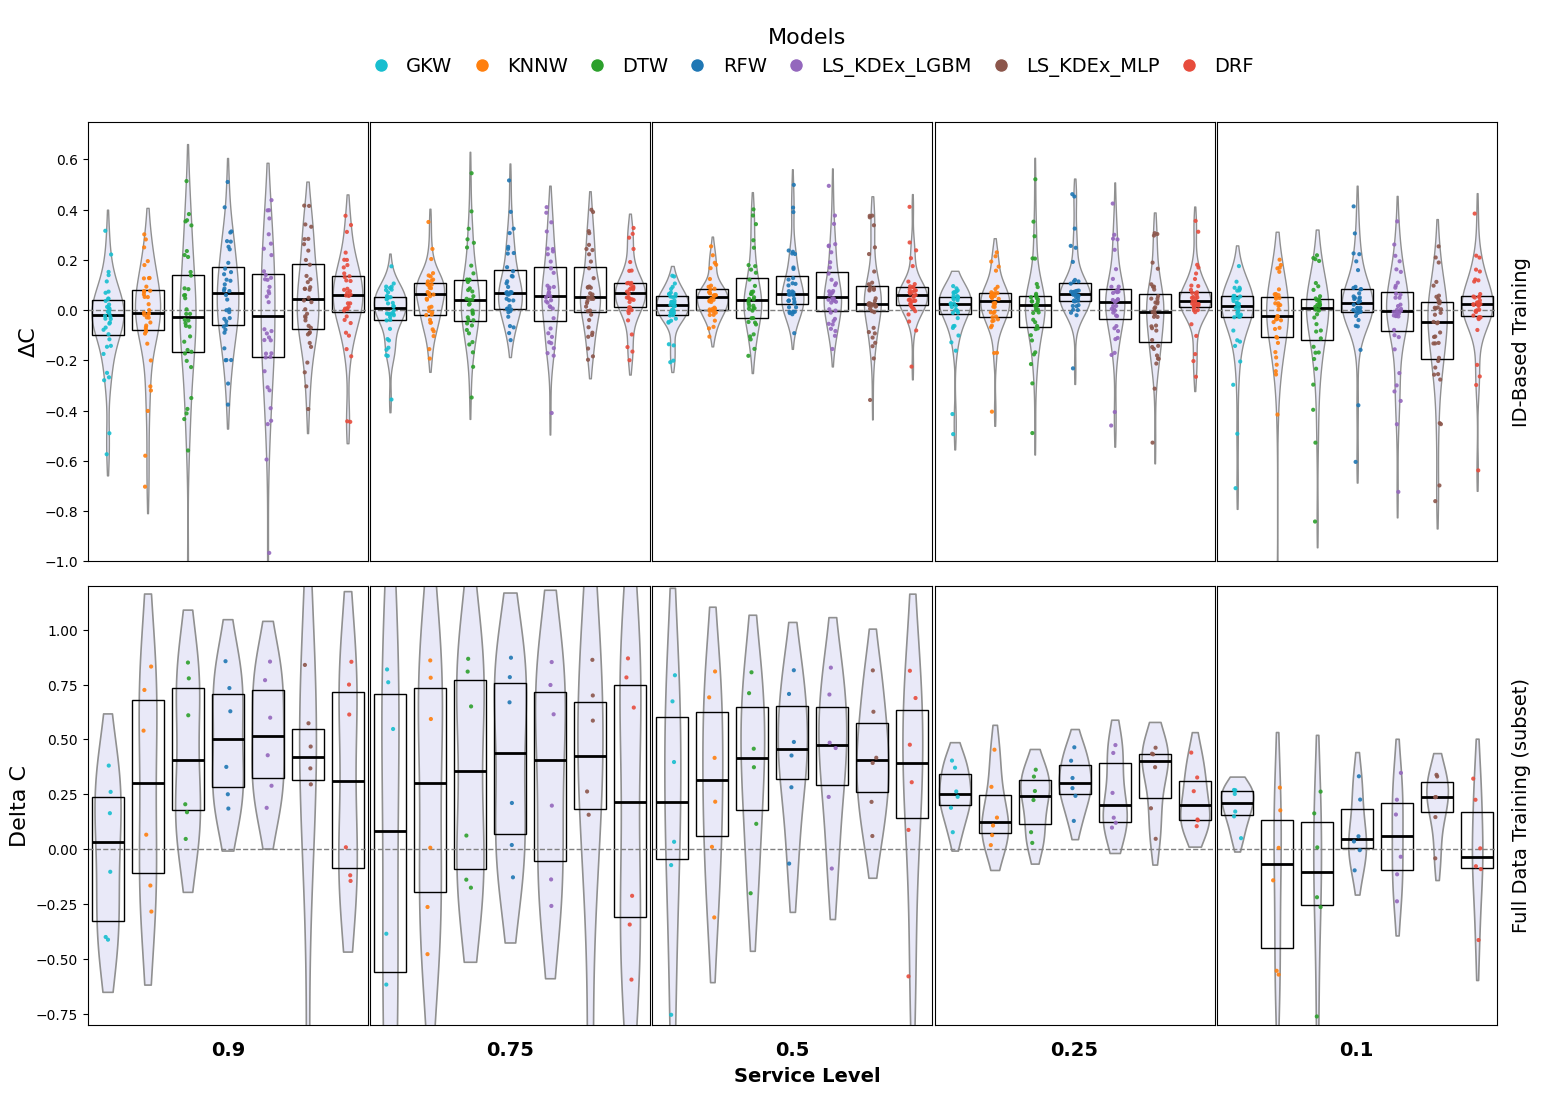

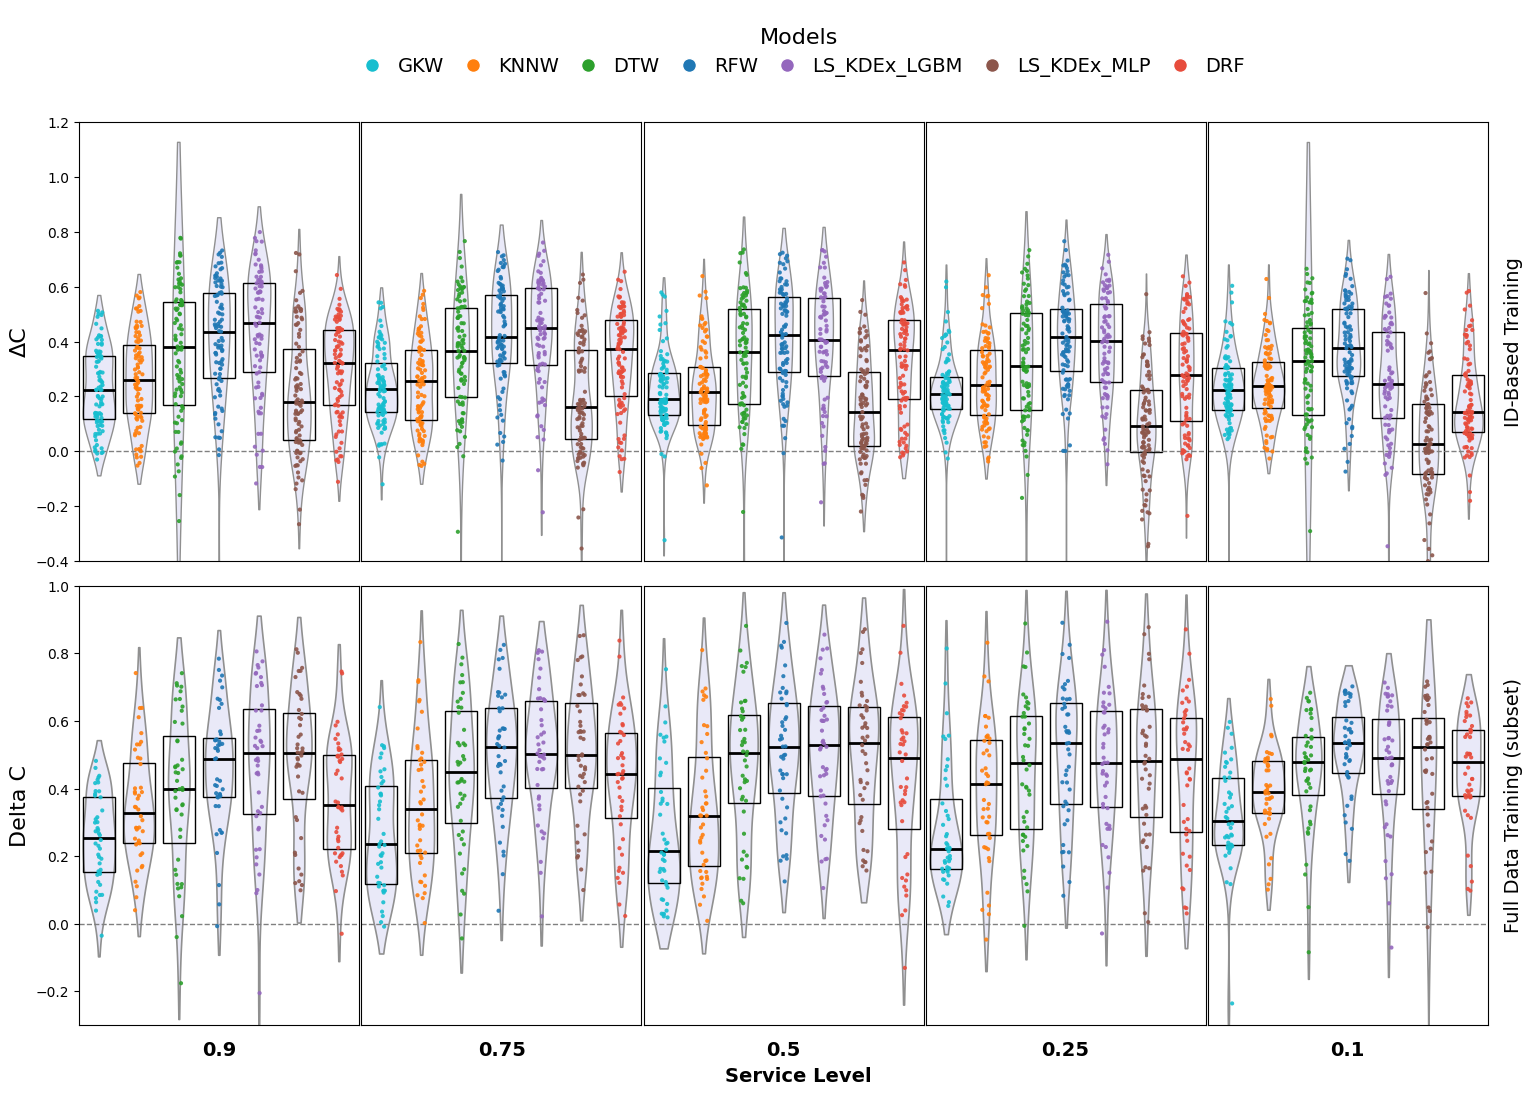

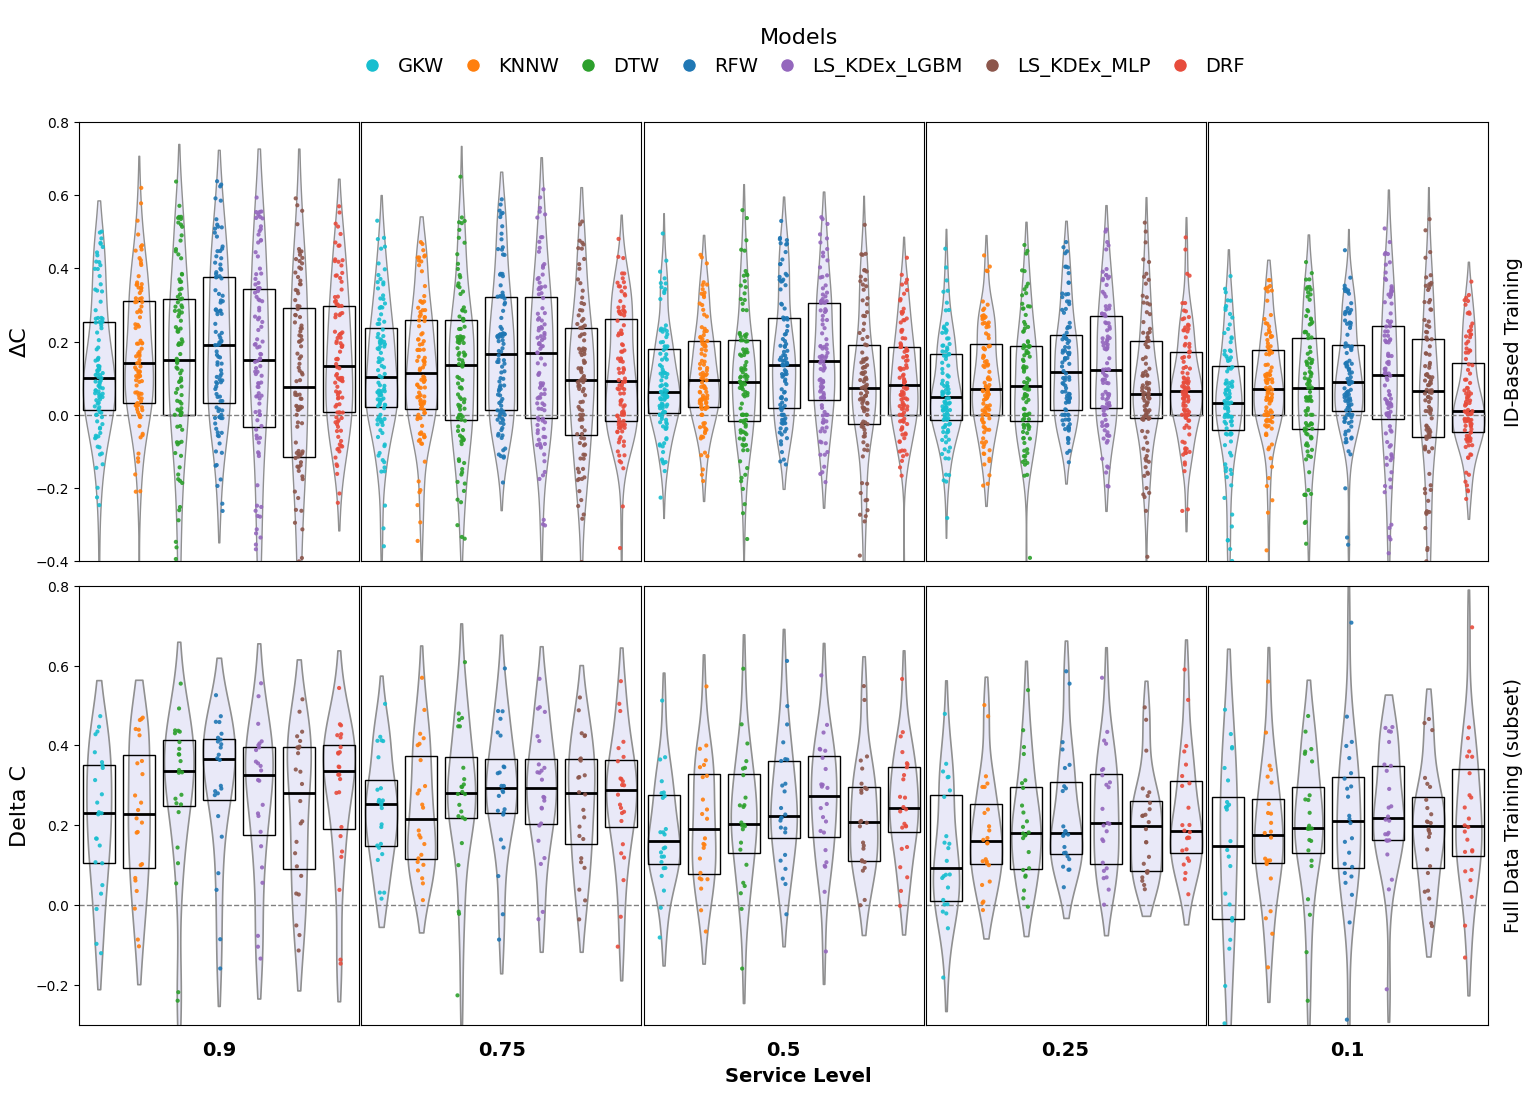

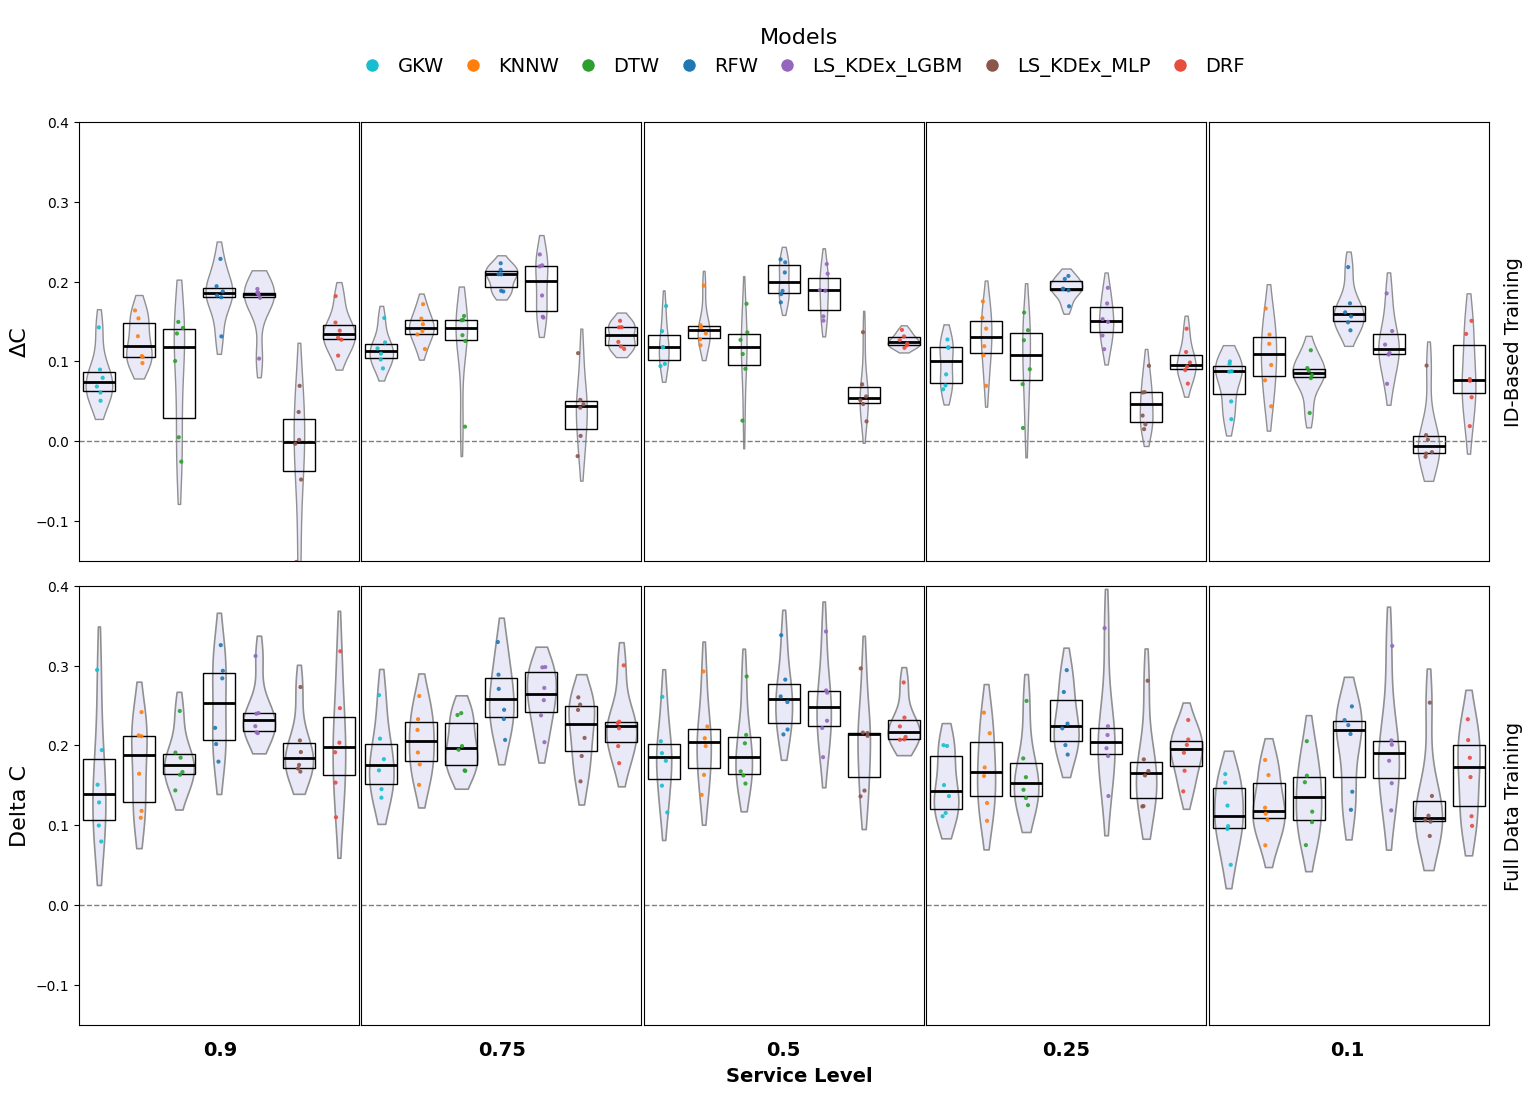

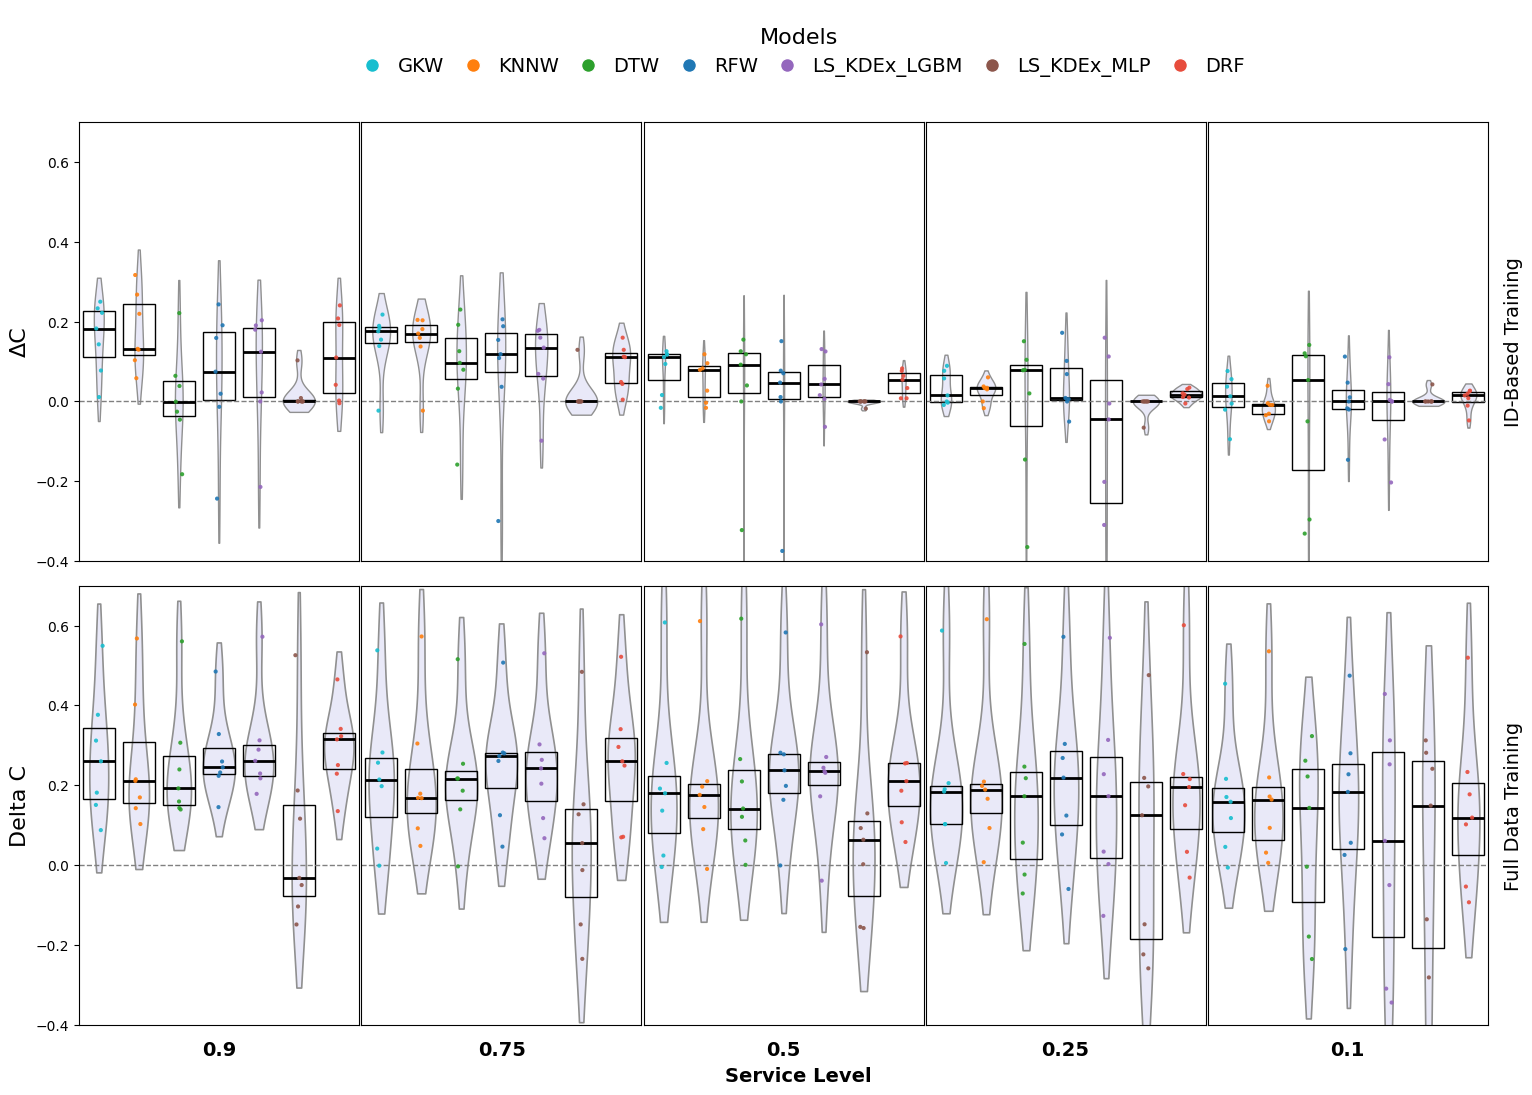

In [7]:
def create_plots(filtered_df, dataset_training_mapping, sl_values, y_limits, model_order, model_colors, datasets, test_instances_mapping):
    for dataset in datasets:
        training_desc_left = 'ID-Based Training'
        training_desc_right = 'Full Data Training'

        dataset_left = dataset_training_mapping[dataset][training_desc_left]
        dataset_right = dataset_training_mapping[dataset][training_desc_right]

        data_left = filtered_df[
            (filtered_df['dataset'] == dataset_left) &
            (filtered_df['training_description'] == training_desc_left)
        ]
        data_right = filtered_df[
            (filtered_df['dataset'] == dataset_right) &
            (filtered_df['training_description'] == training_desc_right)
        ]

        num_sl = len(sl_values)
        total_rows, total_cols = 4, num_sl + 1

        fig = plt.figure(figsize=(16, 13), constrained_layout=False)
        gs = GridSpec(
            total_rows, total_cols, figure=fig,
            height_ratios=[0.2, 1, 1, 0],
            width_ratios=[1] * num_sl + [0.1],
            hspace=0.1, wspace=0.01
        )

        # Legend (Row 0)
        ax_legend = fig.add_subplot(gs[0, :])
        ax_legend.axis('off')
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', label=model, 
                       markerfacecolor=color, markersize=10) 
            for model, color in model_colors.items()
        ]
        ax_legend.legend(
            handles=handles, labels=model_order, loc='upper center', 
            ncol=len(model_order), fontsize=14, frameon=False, title="Models",
            title_fontsize=16, bbox_to_anchor=(0.5, 1.0),
            handletextpad=0.3, columnspacing=0.5
        )

        # ID-Based Training Plots (Row 1)
        for i, sl in enumerate(sl_values):
            ax_left = fig.add_subplot(gs[1, i])
            data_plot_left = data_left[data_left['sl'] == sl]

            sns.violinplot(ax=ax_left, x='Model', y='delta C', data=data_plot_left,
                           order=model_order, color="lavender", inner=None, linewidth=1., cut=1)
            sns.boxplot(ax=ax_left, x='Model', y='delta C', data=data_plot_left,
                        order=model_order, showcaps=False,
                        boxprops=dict(facecolor="none", edgecolor="black", linewidth=1),
                        whiskerprops=dict(visible=False), flierprops=dict(visible=False),
                        medianprops=dict(color="black", linewidth=2))
            sns.stripplot(ax=ax_left, x='Model', y='delta C', data=data_plot_left,
                          order=model_order, palette=model_colors, size=3, jitter=True, alpha=0.9)

            ax_left.axhline(0, color='gray', linestyle='--', linewidth=1)
            ax_left.set_ylim(y_limits.get(dataset_left, (-0.1, 0.1)))
            ax_left.set_xticks([])
            ax_left.set_xlabel('')
            if i == 0:
                ax_left.set_ylabel('ΔC', fontsize=16)
            else:
                ax_left.set_ylabel('')
                ax_left.set_yticks([])

        ax_td_id = fig.add_subplot(gs[1, -1])
        ax_td_id.axis('off')
        ax_td_id.text(0.8, 0.5, 'ID-Based Training', ha='center', va='center', 
                      fontsize=14, rotation=90, transform=ax_td_id.transAxes)

        # Full Data Training Plots (Row 2)
        for i, sl in enumerate(sl_values):
            ax_right = fig.add_subplot(gs[2, i])
            data_plot_right = data_right[data_right['sl'] == sl]

            sns.violinplot(ax=ax_right, x='Model', y='delta C', data=data_plot_right,
                           order=model_order, color="lavender", inner=None, linewidth=1.2, cut=1)
            sns.boxplot(ax=ax_right, x='Model', y='delta C', data=data_plot_right,
                        order=model_order, showcaps=False,
                        boxprops=dict(facecolor="none", edgecolor="black", linewidth=1),
                        whiskerprops=dict(visible=False), flierprops=dict(visible=False),
                        medianprops=dict(color="black", linewidth=2))
            sns.stripplot(ax=ax_right, x='Model', y='delta C', data=data_plot_right,
                          order=model_order, palette=model_colors, size=3, jitter=True, alpha=0.9)

            ax_right.axhline(0, color='gray', linestyle='--', linewidth=1)
            ax_right.set_ylim(y_limits.get(dataset_right, (-0.1, 0.1)))
            ax_right.set_xticks([])
            ax_right.set_xlabel('')
            if i == 0:
                ax_right.set_ylabel('Delta C', fontsize=16)
            else:
                ax_right.set_ylabel('')
                ax_right.set_yticks([])

        ax_td_fd = fig.add_subplot(gs[2, -1])
        ax_td_fd.axis('off')
        full_data_label = 'Full Data Training (subset)' if dataset in ['air', 'bakery', 'm5'] else 'Full Data Training'
        ax_td_fd.text(0.8, 0.5, full_data_label, ha='center', va='center', 
                      fontsize=14, rotation=90, transform=ax_td_fd.transAxes)

        # SL Values (Row 3)
        ax_sl = fig.add_subplot(gs[3, :num_sl])
        ax_sl.axis('off')
        for i, sl in enumerate(sl_values):
            x_pos = (i + 0.5) / num_sl
            ax_sl.text(x_pos, 0.5, str(sl), ha='center', va='center', 
                       fontsize=14, fontweight='bold', transform=ax_sl.transAxes)

        fig.text(0.5, 0.08, 'Service Level', fontsize=14, fontweight='bold', ha='center', va='center')

        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
        plt.savefig(f'violinplot_{dataset}.png', dpi=300, bbox_inches='tight')
        plt.show()

create_plots(
    filtered_df=filtered_df, 
    dataset_training_mapping=dataset_training_mapping, 
    sl_values=sl_values, 
    y_limits=y_limits, 
    model_order=model_order, 
    model_colors=model_colors, 
    datasets=datasets, 
    test_instances_mapping=test_instances_mapping
)


### Line Plots


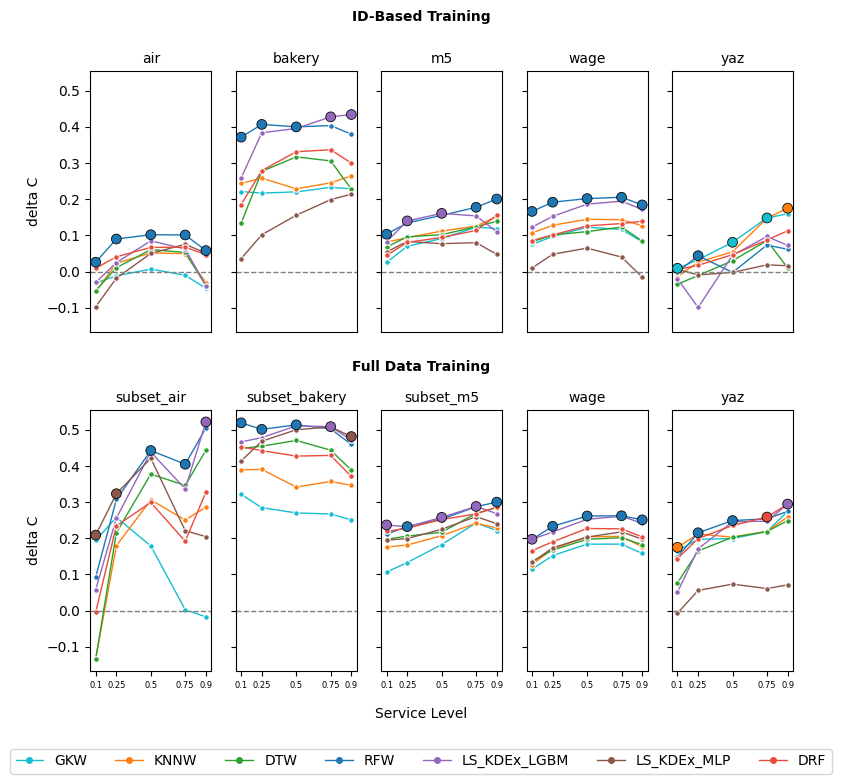

In [8]:
# Erstelle die Subplots
fig, axes = plt.subplots(
    2, 
    len(dataset_names["ID-Based Training"]), 
    figsize=(8.27, 10), 
    sharey=True
)

# Setze Titel und X-Achsenbeschriftungen korrekt
for row, (training_type, datasets) in enumerate(dataset_names.items()):
    for col, dataset in enumerate(datasets):
        ax = axes[row, col]
        
        # Filter für spezifisches Dataset und Training-Typ
        filtered_data = filtered_df[
            (filtered_df['dataset'] == dataset) & 
            (filtered_df['training_description'] == training_type)
        ]

        if filtered_data.empty:
            # Falls keine Daten vorhanden sind, überspringen
            ax.set_title(f'{dataset}', fontsize=10)
            ax.axhline(0, color='gray', linestyle='--', linewidth=1)
            continue

        # Berechne den durchschnittlichen delta C pro Model und SL
        avg_delta_c = filtered_data.groupby(['sl', 'Model'])['delta C'].mean().reset_index()

        # Identifiziere das beste Model pro SL basierend auf dem durchschnittlichen delta C
        best_models_per_sl = avg_delta_c.loc[avg_delta_c.groupby('sl')['delta C'].idxmax()]

        # Linienplot für alle Modelle mit einheitlicher Linienbreite und Markergröße
        sns.lineplot(
            ax=ax,
            data=filtered_data,
            x='sl',
            y='delta C',
            hue='Model',
            hue_order=model_order,
            palette=model_colors,
            marker='o',
            linewidth=1,  # Einheitliche Linienbreite
            markersize=4,  # Einheitliche Markergröße
            legend=False,  # Keine Legende in den Subplots
            ci=None  # Keine Konfidenzintervalle
        )

        # Plot die hervorgehobenen Marker über den bestehenden Markern
        sns.scatterplot(
            ax=ax,
            data=best_models_per_sl,
            x='sl',
            y='delta C',
            hue='Model',
            hue_order=model_order,
            palette=model_colors,
            marker='o',
            edgecolor='black',  # Schwarzer Rand für bessere Sichtbarkeit
            s=50,  # Größere Markergröße
            zorder=5,  # Über den Linien plotten
            legend=False  # Keine zusätzliche Legende
        )

        # Füge gestrichelte Linie bei y=0 hinzu
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)

        # Setze Titel für die obere Zeile
        if row == 0:
            ax.set_title(f'{dataset}', fontsize=10)

        # Setze Titel für die untere Zeile, inkl. vollständigem Datensatznamen
        if row == 1:
            mapped_dataset = dataset  # Falls du eine Mapping-Funktion hast, andernfalls direkt dataset verwenden
            ax.set_title(f'{mapped_dataset}', fontsize=10)

        # Entferne X-Achsenbeschriftung und Ticks für die obere Zeile
        if row == 0:
            ax.set_xticks([])  # Entfernt die X-Achsen-Ticks
            ax.set_xlabel('')  # Entfernt jegliche x-Achsen-Beschriftung

        # Entferne die individuelle x-Achsenbeschriftung für die untere Zeile
        if row == 1:
            ax.set_xticks([0.1, 0.25, 0.5, 0.75, 0.9])
            ax.set_xticklabels(['0.1', '0.25', '0.5', '0.75', '0.9'], fontsize=6)  # Nur Zahlenwerte
            ax.set_xlabel('')  # Entfernt jegliche x-Achsen-Beschriftung

        # Entferne die Legende von den Subplots, falls sie existiert
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

# Globale Legende unterhalb der Grafik
handles = [plt.Line2D([0], [0], color=color, marker='o', linestyle='-', lw=1, 
                      markersize=4, label=model) for model, color in model_colors.items()]
fig.legend(handles, model_colors.keys(), loc='lower center', ncol=len(model_colors), fontsize=10, frameon=True, bbox_to_anchor=(0.5, 0.09))

# Passen Sie den Abstand zwischen den Subplots an
plt.subplots_adjust(
    hspace=0.3,    # Erhöht den vertikalen Abstand zwischen den Reihen
    bottom=0.2,    # Erhöht den unteren Rand der gesamten Figur
    top=0.8,      # Optionale Anpassung des oberen Rands
    left=0.1,      # Linker Rand (optional anpassbar)
    right=0.95      # Rechter Rand (optional anpassbar)
)  # Abstand zwischen den beiden Plot-Reihen und Platz für Legende

# Untertitel für beide Plots
plt.figtext(0.5, 0.85, 'ID-Based Training', ha='center', fontsize=10, weight='bold')  # Erster Untertitel
plt.figtext(0.5, 0.5, 'Full Data Training', ha='center', fontsize=10, weight='bold')  # Zweiter Untertitel, direkt über dem unteren Plot

# Gemeinsame X-Achsenbeschriftung
fig.supxlabel('Service Level', fontsize=10, y=0.15)  # Position leicht oberhalb der Legende

plt.savefig('results_all_Datasets_SL.png', dpi=300, bbox_inches='tight')
plt.show()

### Best Model per ID

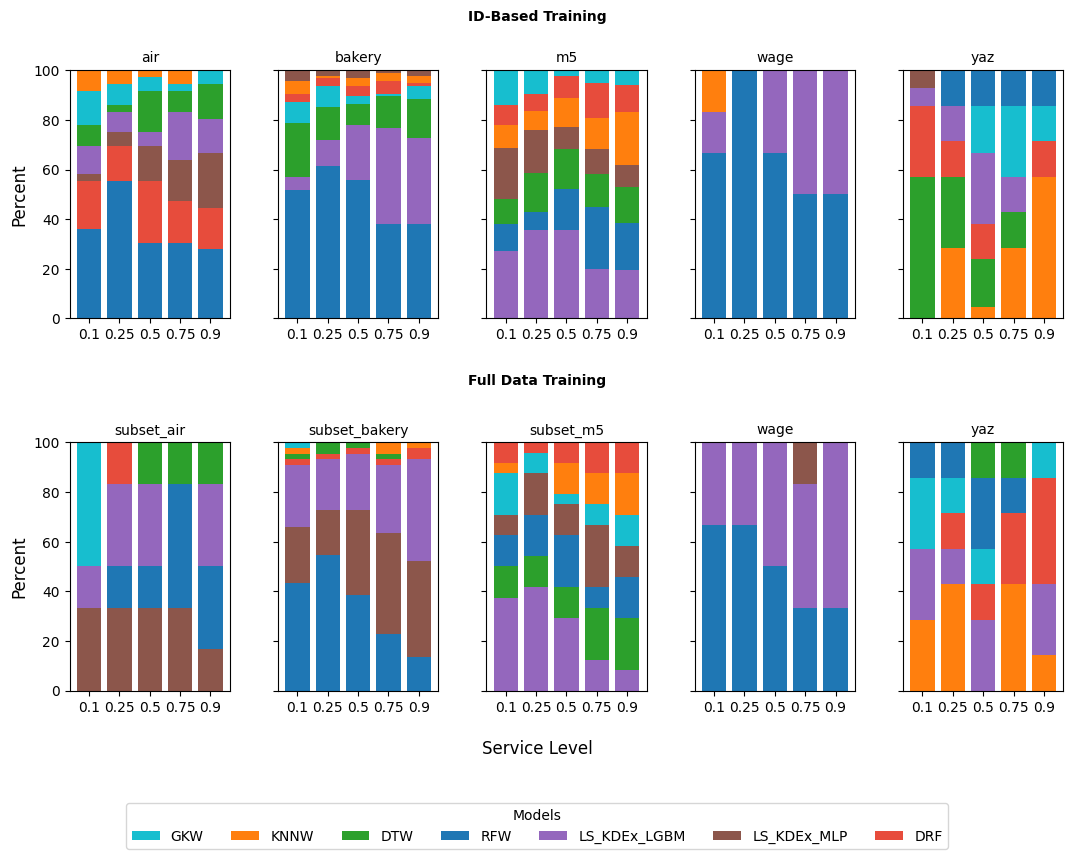

In [9]:
# Vorbereitungen für die Subplots
filtered_df = df[~df['Model'].isin(excluded_models)]
training_descriptions = filtered_df['training_description'].unique()
datasets_per_training = [filtered_df[filtered_df['training_description'] == td]['dataset'].nunique() for td in training_descriptions]
num_trainings, max_datasets = len(training_descriptions), max(datasets_per_training)

fig, axes = plt.subplots(nrows=num_trainings, ncols=max_datasets, figsize=(11.69, 8.27), sharey=True)
if num_trainings == 1 and max_datasets == 1:
    axes = np.array([[axes]])
elif num_trainings == 1:
    axes = axes.reshape(1, max_datasets)
elif max_datasets == 1:
    axes = axes.reshape(num_trainings, 1)

# Loop über Trainingsbeschreibungen und Datasets
for row_idx, td in enumerate(training_descriptions):
    td_df = filtered_df[filtered_df['training_description'] == td]
    datasets = td_df['dataset'].unique()

    for col_idx in range(max_datasets):
        ax = axes[row_idx, col_idx]
        if col_idx < len(datasets):
            dataset_df = td_df[td_df['dataset'] == datasets[col_idx]]
            service_levels = sorted(dataset_df['sl'].unique())
            variables = dataset_df['Variable'].unique()

            best_model_counts_per_sl = {}
            for sl in service_levels:
                sl_df = dataset_df[dataset_df['sl'] == sl]
                best_model_counts = {model: 0 for model in model_colors.keys()}
                for var in variables:
                    var_df = sl_df[sl_df['Variable'] == var]
                    if not var_df.empty:
                        min_loss = var_df['Pinball Loss'].min()
                        best_models = var_df[var_df['Pinball Loss'] == min_loss]['Model'].unique()
                        for bm in best_models:
                            best_model_counts[bm] += 1.0 / len(best_models)

                total_vars = len(variables)
                for model in best_model_counts:
                    best_model_counts[model] = (best_model_counts[model] / total_vars) * 100
                best_model_counts_per_sl[sl] = best_model_counts

            total_percentages = {model: sum(best_model_counts_per_sl[sl].get(model, 0) for sl in service_levels) for model in model_colors.keys()}
            sorted_models = sorted(total_percentages, key=total_percentages.get, reverse=True)

            x = np.arange(len(service_levels))
            bottoms = np.zeros(len(service_levels))

            for model in sorted_models:
                percentages = [best_model_counts_per_sl[sl][model] for sl in service_levels]
                ax.bar(x, percentages, bottom=bottoms, color=model_colors[model])
                bottoms += percentages

            ax.set_xticks(x)
            ax.set_xticklabels([str(sl) for sl in service_levels], fontsize=10)
            if col_idx == 0:
                ax.set_ylabel('Percent', fontsize=12)
            ax.set_title(f"{datasets[col_idx]}", fontsize=10)
        else:
            ax.set_visible(False)

# Beschriftungen und Legende
plt.subplots_adjust(bottom=0.15, top=0.9, left=0.1, right=0.95, hspace=0.5, wspace=0.3)
fig.text(0.5, 0.08, 'Service Level', ha='center', va='center', fontsize=12)
handles = [Patch(facecolor=model_colors[model], label=model) for model in model_colors.keys()]
fig.legend(handles, model_colors.keys(), title='Models', bbox_to_anchor=(0.5, -0.05), loc='lower center', ncol=len(model_colors), fontsize=10)
plt.figtext(0.5, 0.96, 'ID-Based Training', ha='center', fontsize=10, weight='bold')
plt.figtext(0.5, 0.52, 'Full Data Training', ha='center', fontsize=10, weight='bold')

plt.savefig(f'best_Model_per_ID.png', dpi=300, bbox_inches='tight')
plt.show()


### Model Selection Approach


--> Find the Best Model for Each ID Using Cross-Validation (Mean Test Score)


In [10]:
model_results = filtered_df
cv_results = pd.read_csv(file_path_CVresults) 


# Spalte 'Model' in 'model_name' umbenennen
model_results.rename(columns={'Model': 'model_name'}, inplace=True)
model_results.rename(columns={'Variable': 'variable'}, inplace=True)

cv_results = pd.read_csv(file_path_CVresults)
cv_results = cv_results[~cv_results['model_name'].isin(excluded_models)]
cv_results.rename(columns={'tau': 'sl'}, inplace=True)

cv_results_raw = cv_results

# align all signs to negative ones
split_columns = [col for col in cv_results.columns if col.startswith('split') and '_test_score' in col]

cv_results_raw.loc[cv_results['model_name'] == 'DRF', 'model_type'] = 'basic_models'
cv_results_raw.loc[cv_results['model_type'] == 'levelset_models', split_columns] *= -1

# Kopieren der rohen CV-Ergebnisse
cv_results = cv_results_raw.copy()

# Berechnung des mean_test_score
cv_results['mean_test_score'] = cv_results[
    [col for col in cv_results.columns if col.startswith('split') and '_test_score' in col]
].mean(axis=1)

# Auswahl relevanter Spalten
cv_results = cv_results[['mean_test_score', 'dataset', 'training_description',
                         'variable', 'model_name', 'sl', 'hyperparameter']]

# Initialisiere die Endtabelle
final_best_models = pd.DataFrame()

# Verarbeitung je Training Description
for training_desc, datasets in dataset_names.items():
    # Filtere die Daten für die aktuelle Trainingsbeschreibung
    filtered_cv_results = cv_results[
        (cv_results['training_description'] == training_desc) &
        (cv_results['dataset'].isin(datasets))
    ]
    
    # Auswahl der besten Modelle pro Parameter-Gitter
    best_model_per_grid = filtered_cv_results.loc[
        filtered_cv_results.groupby(["dataset", "variable", "model_name", "sl"])["mean_test_score"].idxmax()
    ]

    # Rangordnung der besten Modelle
    best_model_per_grid["rank"] = best_model_per_grid.groupby(
        ["dataset", "variable", "sl"]
    )["mean_test_score"].rank("min", ascending=False)

    # Auswahl der besten Modelle pro Kombination
    best_cv_model_per_group = best_model_per_grid.loc[
        best_model_per_grid.groupby(["dataset", "variable", "sl"])["mean_test_score"].idxmax()
    ]

    # Hinzufügen zur Endtabelle
    final_best_models = pd.concat([final_best_models, best_cv_model_per_group])

# Zähle, wie oft jedes Modell das beste Modell war, gruppiert nach Dataset und Training Description
best_model_counts = final_best_models.groupby(["dataset", "training_description"])["model_name"].value_counts()

# Endtabelle anzeigen
display(final_best_models.head(2))

best_cv_models = final_best_models




,mean_test_score,dataset,training_description,variable,model_name,sl,hyperparameter,rank
29954,-0.012043,air,ID-Based Training,Location_1_max_CO,RFW,0.10,"{'param_max_depth': 8.0, 'param_n_estimators':...",1.0
24915,-0.022491,air,ID-Based Training,Location_1_max_CO,RFW,0.25,"{'param_max_depth': 8.0, 'param_n_estimators':...",1.0


--> and merge it to the actuall results (pinball loss here)

In [11]:
# Split von best_cv_models nach "training_description"
id_based_models = best_cv_models[best_cv_models['training_description'] == "ID-Based Training"]
full_data_models = best_cv_models[best_cv_models['training_description'] == "Full Data Training"]

id_based_result = id_based_models.merge(
    model_results[model_results['training_description'] == "ID-Based Training"],
    on=["dataset", "training_description", "variable", "model_name", "sl"],
    how="left"
)

# Merge für "Full Data Training"
full_data_result = full_data_models.merge(
    model_results[model_results['training_description'] == "Full Data Training"],
    on=["dataset", "training_description", "model_name", "sl"],  # Ohne "variable"
    how="left"
)
# Zusammenführen der Ergebnisse
final_best_selection_with_test = pd.concat([id_based_result, full_data_result], ignore_index=True)

# Bedingung für "Full Data Training"
condition = final_best_selection_with_test['training_description'] == 'Full Data Training'

final_best_selection_with_test.loc[condition, ['variable', 'variable_y']] = \
    final_best_selection_with_test.loc[condition, ['variable_y', 'variable']].values

display(final_best_selection_with_test.head(2))

,mean_test_score,dataset,training_description,variable,model_name,sl,hyperparameter,rank,cu,co,Pinball Loss,Best Params,delta C,variable_x,variable_y
0,-0.012043,air,ID-Based Training,Location_1_max_CO,RFW,0.10,"{'param_max_depth': 8.0, 'param_n_estimators':...",1.0,1.0,9.0,0.031873,"OrderedDict([('max_depth', 8), ('max_features'...",0.159112,NaN,NaN
1,-0.022491,air,ID-Based Training,Location_1_max_CO,RFW,0.25,"{'param_max_depth': 8.0, 'param_n_estimators':...",1.0,2.5,7.5,0.063252,"OrderedDict([('max_depth', 8), ('max_features'...",0.255561,NaN,NaN


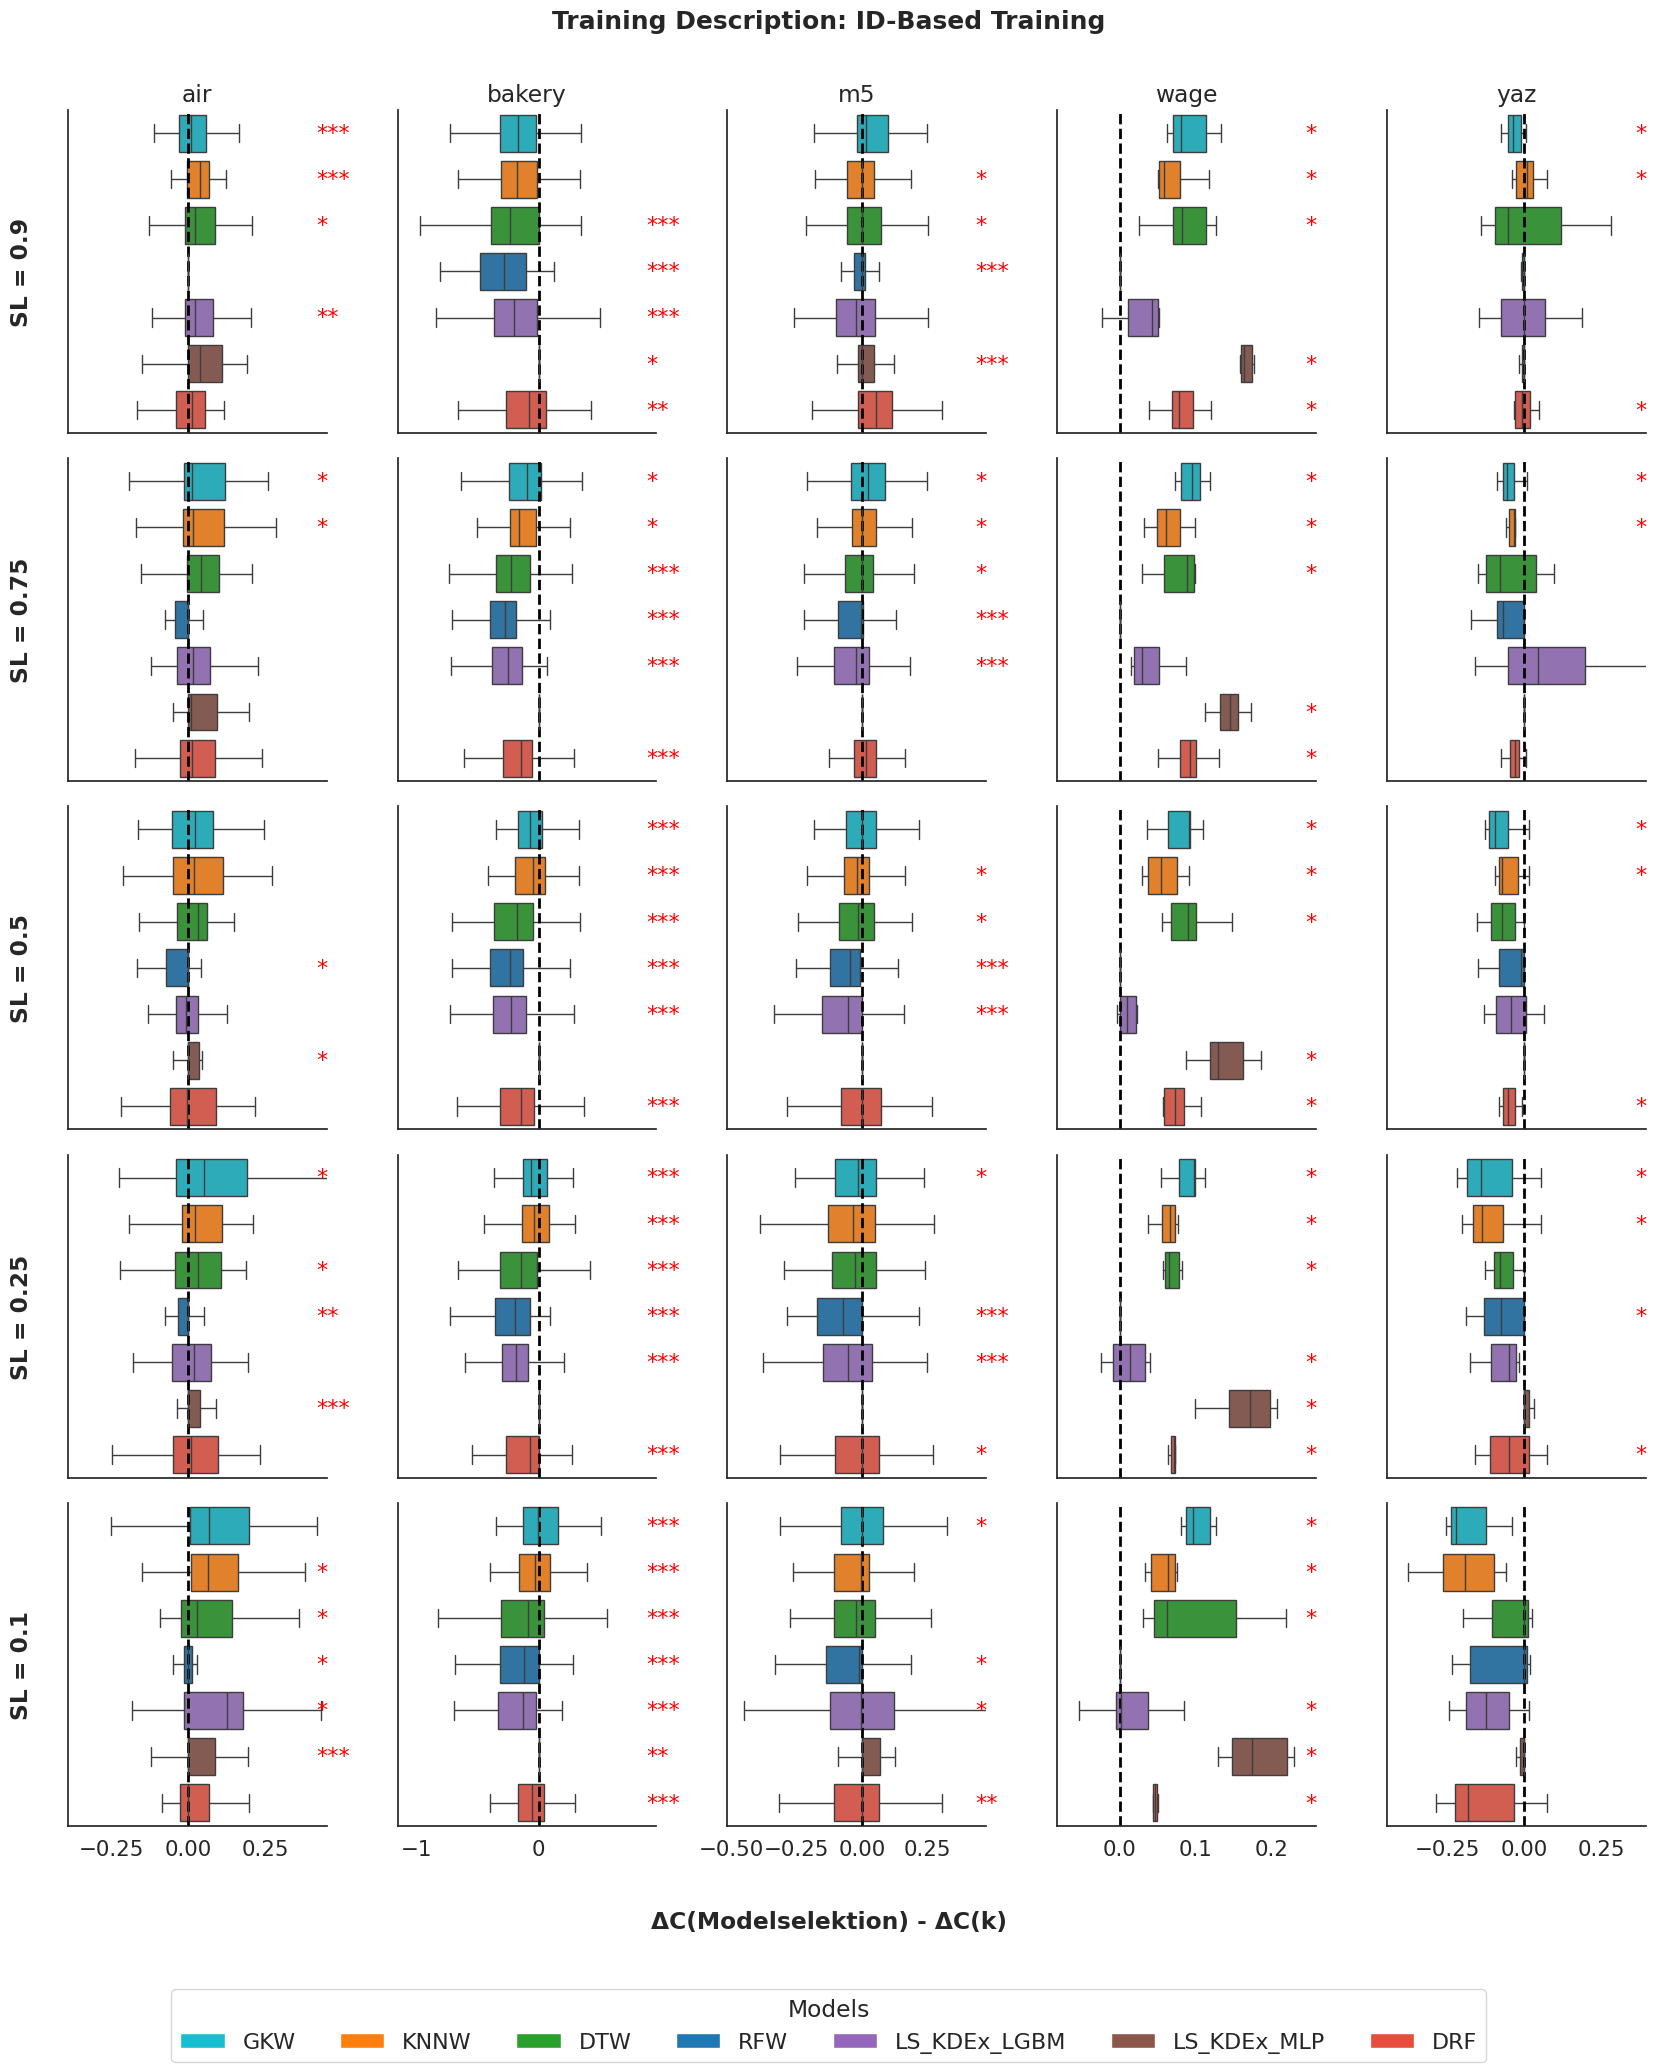

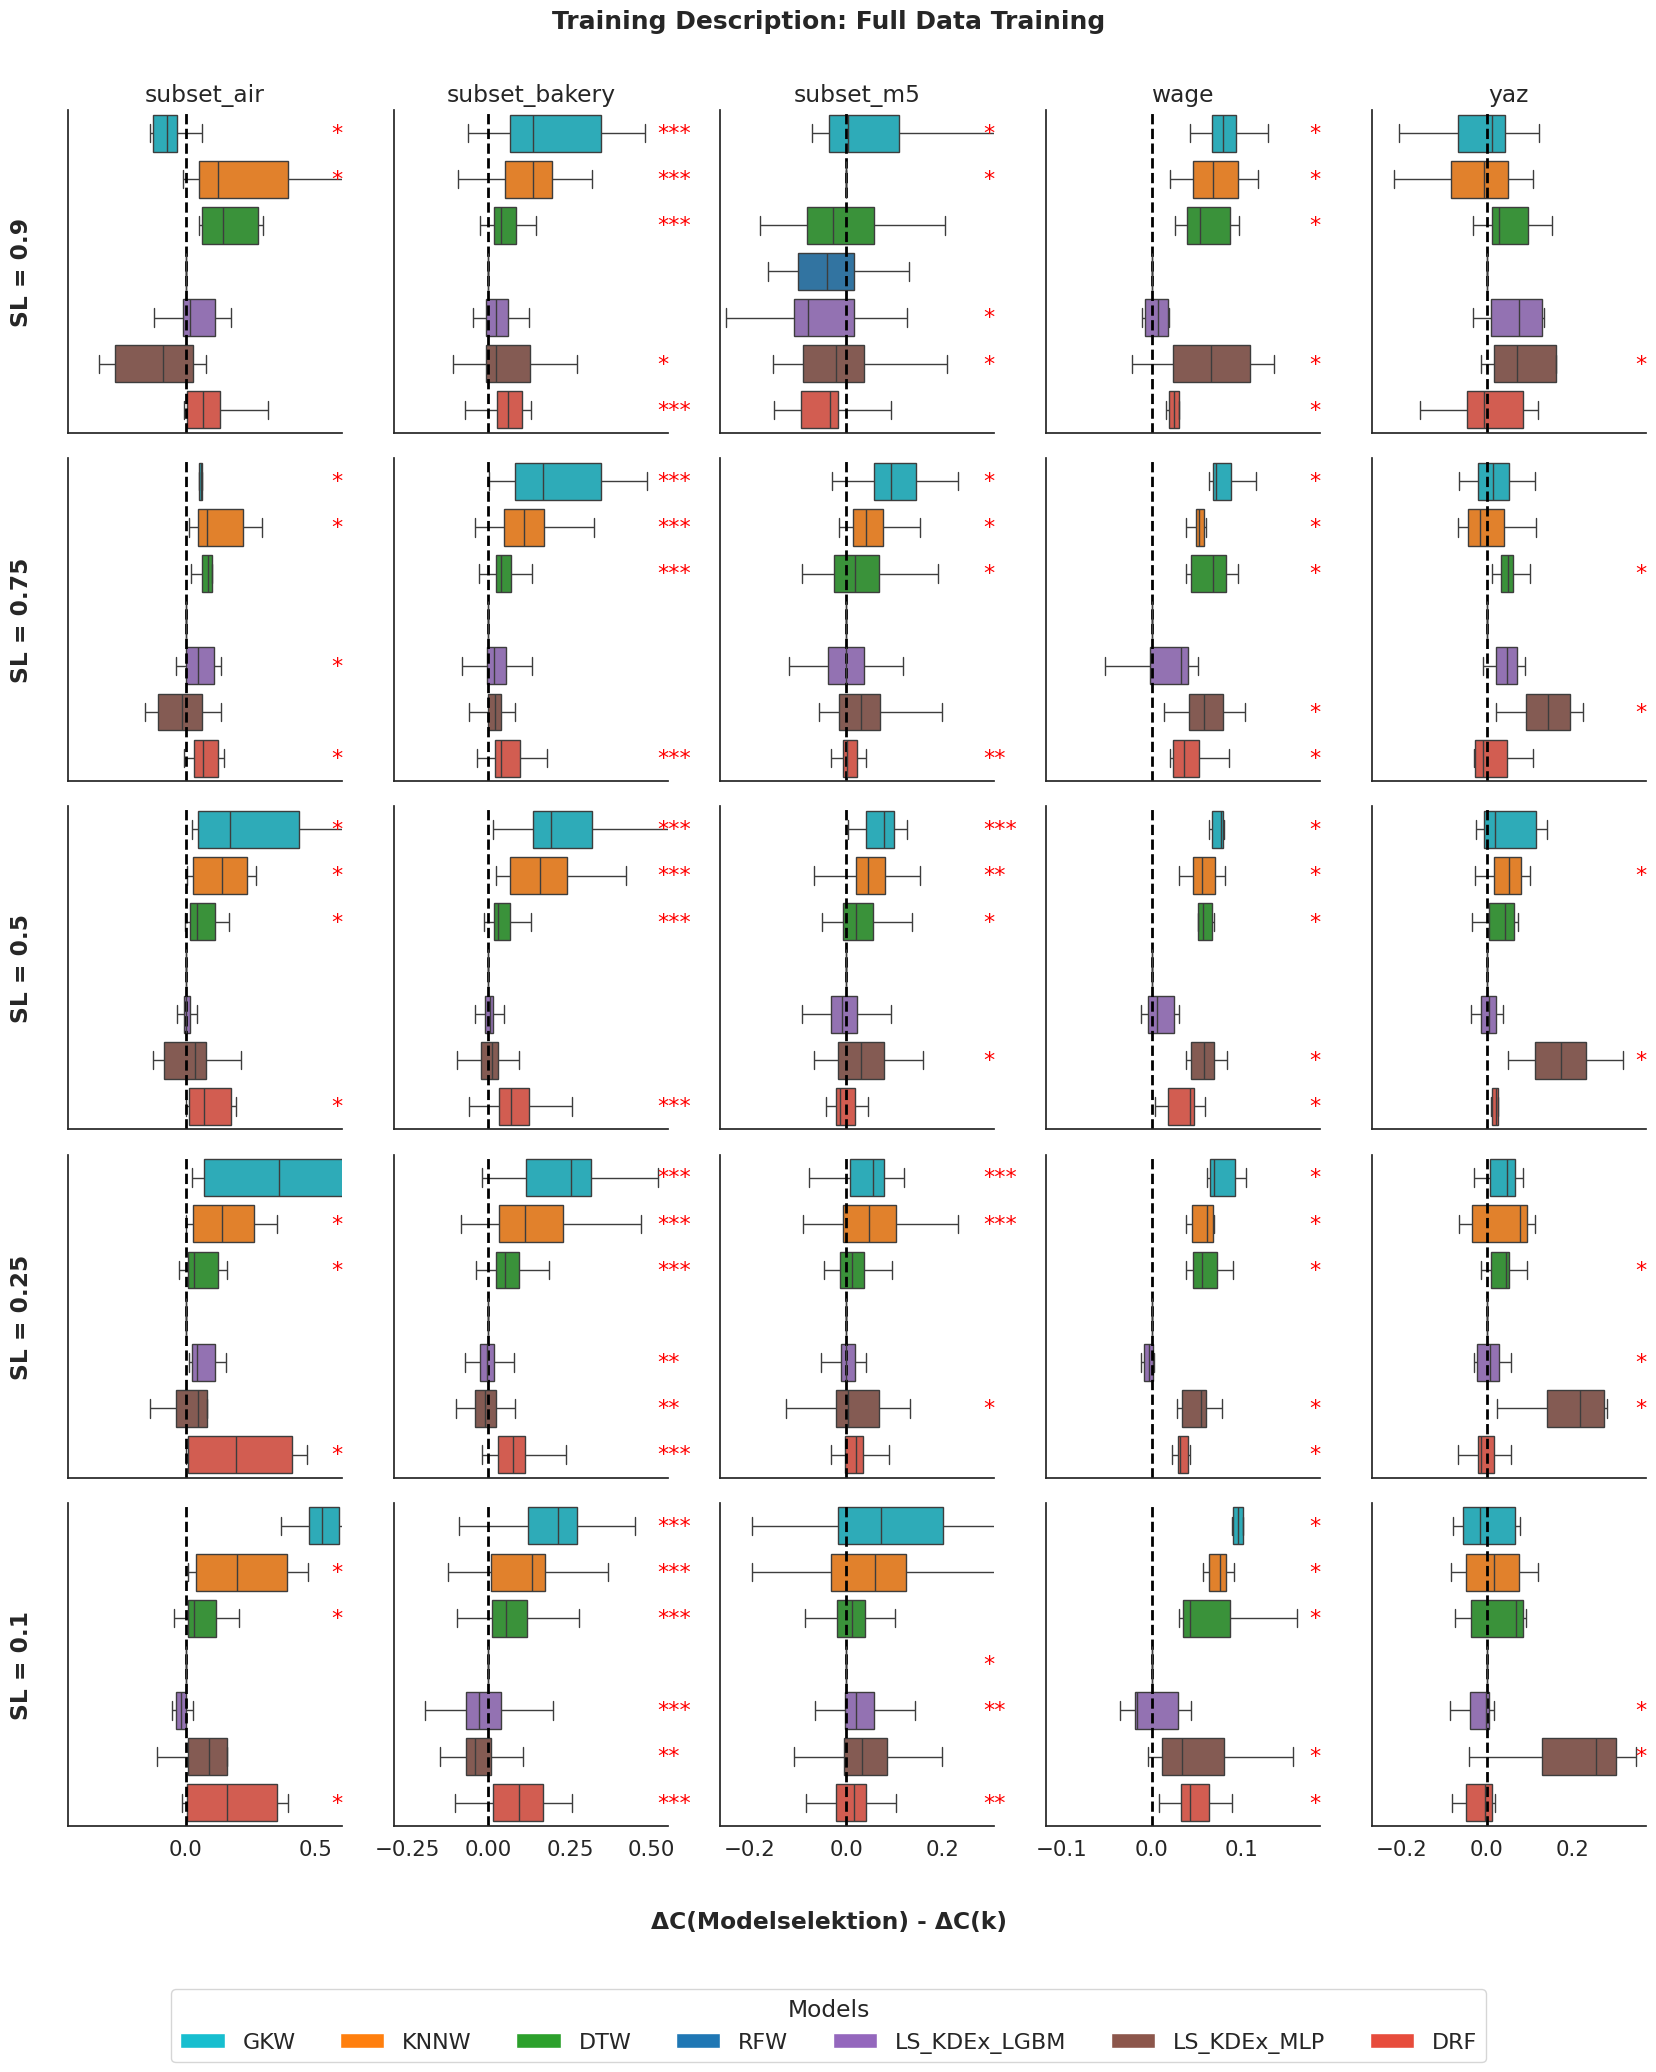

In [12]:
models = model_order

significance_marker = lambda p: "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.1 else ""))

for training_description in training_descriptions:
    merged_all_sl = pd.DataFrame()
    for SL in sl_values:
        final_best_sel = final_best_selection_with_test[
            (final_best_selection_with_test['sl'] == SL) &
            (final_best_selection_with_test['training_description'] == training_description)
        ]
        model_results_sel = model_results[
            (model_results['sl'] == SL) &
            (model_results['training_description'] == training_description)
        ]

        if final_best_sel.empty or model_results_sel.empty:
            continue

        model_selection = final_best_sel[['variable', 'dataset', 'delta C']].copy()
        model_selection.rename(columns={'delta C': 'delta_C_model_selection'}, inplace=True)

        model_results_sel = model_results_sel[['variable', 'dataset', 'model_name', 'delta C']].copy()
        model_results_sel.rename(columns={'delta C': 'delta_C_model'}, inplace=True)

        merged = pd.merge(model_results_sel, model_selection, on=['variable', 'dataset'], how='left')
        merged['∆C(model selection)-∆C(k)'] = merged['delta_C_model_selection'] - merged['delta_C_model']
        merged = merged[merged['model_name'].isin(models)]
        merged['sl'] = SL

        merged_all_sl = pd.concat([merged_all_sl, merged], ignore_index=True)

    if merged_all_sl.empty:
        print(f"Keine Daten zum Plotten für Training Description: {training_description}")
        continue

    if 'dataset' in merged_all_sl.columns and not merged_all_sl['dataset'].isnull().all():
        datasets = merged_all_sl['dataset'].unique()
    else:
        datasets = []

    if len(datasets) == 0:
        print(f"Keine Daten zum Plotten für Training Description: {training_description}")
        continue

    # Berechnung der x-Achsen-Grenzen pro Datensatz mit Ausreißerentfernung
    dataset_limits = []
    for dataset_name in datasets:
        subset = merged_all_sl[merged_all_sl["dataset"] == dataset_name]["∆C(model selection)-∆C(k)"]
        
        if len(subset) > 0:
            q1 = subset.quantile(0.25)
            q3 = subset.quantile(0.75)
            iqr = q3 - q1
            filtered_subset = subset[(subset >= (q1 - 3 * iqr)) & (subset <= (q3 + 3 * iqr))]
            
            if len(filtered_subset) > 0:
                dataset_limits.append({
                    "dataset": dataset_name,
                    "min": filtered_subset.min(),
                    "max": filtered_subset.max()
                })

    dataset_limits = pd.DataFrame(dataset_limits)

    sns.set_theme(style="white", font_scale=1.4)
    g = sns.catplot(
        y="model_name",
        x="∆C(model selection)-∆C(k)",
        data=merged_all_sl,
        kind="box",
        hue="model_name",
        col="dataset",
        row="sl",
        col_order=datasets,
        order=models,
        sharex=False,
        sharey=True,
        dodge=False,
        orient='h',
        showfliers=False,
        height=3.75,
        aspect=0.9,
        legend=False,  # Legende deaktiviert, wir fügen sie manuell hinzu
        palette=model_colors
    )

    # Automatische Titel entfernen
    g.set_titles("")

    # Datensatznamen nur in der obersten Zeile anzeigen
    for col_i, dataset_name in enumerate(datasets):
        g.axes[0, col_i].set_title(dataset_name)

    # Entferne Achsenlabels bei den Subplots
    g.set_axis_labels("", "")

    # Y-Achsenticks und Labels entfernen
    for ax_row in g.axes:
        for ax in ax_row:
            ax.set_yticks([])
            ax.set_yticklabels([])

    # Vertikale Referenzlinie und Anpassung der x-Achse
    for r_i, sl_val in enumerate(sl_values):
        for c_i, dataset_name in enumerate(datasets):
            ax = g.axes[r_i, c_i]

            # Grenzen für den aktuellen Datensatz abrufen
            limits = dataset_limits[dataset_limits["dataset"] == dataset_name]
            if not limits.empty:
                x_min = limits["min"].iloc[0]
                x_max = limits["max"].iloc[0]

                # Etwas Puffer hinzufügen
                padding = 0.1 * (x_max - x_min)
                ax.set_xlim(x_min - padding, x_max + padding)

            # Vertikale Referenzlinie bei x=0
            ax.axvline(0, color="black", linestyle="--", linewidth=2)

            # Nur für die letzte Zeile (r_i == len(sl_values) - 1) die x-Achsen-Ticks anzeigen
            if r_i < len(sl_values) - 1:
                ax.set_xticklabels([])
                ax.set_xlabel("")

    # Wilcoxon-Test und Signifikanzmarkierungen
    for r_i, sl_val in enumerate(sl_values):
        for c_i, dataset_name in enumerate(datasets):
            ax = g.axes[r_i, c_i]
            for model_i, model_name in enumerate(models):
                subset = merged_all_sl[
                    (merged_all_sl['dataset'] == dataset_name) &
                    (merged_all_sl['model_name'] == model_name) &
                    (merged_all_sl['sl'] == sl_val)
                ]
                if len(subset) > 0:
                    values = subset['∆C(model selection)-∆C(k)']
                    if (values == 0).all():
                        continue
                    w = pg.wilcoxon(values, y=None, alternative='two-sided')
                    p_value = w['p-val'].values[0]

                    marker = significance_marker(p_value)
                    if marker:
                        max_val = values.max()
                        axis_min, axis_max = ax.get_xlim()

                        x_offset = 0.04 * (axis_max - axis_min)
                        x_pos = axis_max - x_offset

                        ax.text(x_pos, model_i, marker, va='center', ha='left', fontsize=16, color='red')

    # -- Beschriftung der Zeilen (SL) auf der linken Seite --
    for r_i, sl_val in enumerate(sl_values):
        # linke Spalte => c_i = 0
        ax = g.axes[r_i, 0]
        ax.set_ylabel(f"SL = {sl_val}", rotation=90, labelpad=25, fontweight='bold')  
        # labelpad vergrößert den Abstand, damit es lesbar ist

    # Manuelle Legende anlegen
    fig = g.fig  # Das Figure-Objekt des Catplot
    handles = [Patch(facecolor=model_colors[m], label=m) for m in model_colors.keys()]
    # Legende direkt unter dem Plot zentriert
    fig.legend(
        handles,
        model_colors.keys(),
        title='Models',
        bbox_to_anchor=(0.5, -0.05),  # x=0.5 => mittig, y=-0.05 => etwas unterhalb
        loc='upper center',
        ncol=len(model_colors),
        fontsize=16
    )

    # Falls Legende abgeschnitten wird, mehr Platz unten einplanen
    plt.subplots_adjust(top=1, bottom=0.3)

    g.fig.suptitle(f"Training Description: {training_description}", fontsize=18, y=1, weight='bold')
    g.fig.text(0.5, -0.02, "ΔC(Modelselektion) - ΔC(k)", ha='center', va='center', weight='bold')

    plt.tight_layout()
    plt.savefig(f'model_selection_approach_{training_description}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
